# Project 2: Data Representations and Clustering 

### Part 3 - Clustering using Both Image and Text

In [128]:
!pip install datasets transformers numpy pandas Pillow matplotlib 
!pip install torch tqdm scipy
!pip install git+https://github.com/openai/CLIP.git
!pip install plotly umap-learn

In [147]:
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import clip
import torch
from tqdm import tqdm
from scipy.special import softmax
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [148]:
# load csv file and image paths to construct pokedex, use type_to_load=None to load all types, else use a list of types 1 to load
def construct_pokedex(csv_path='Pokemon.csv', image_dir='./images/', type_to_load=None):
    pokedex = pd.read_csv(csv_path)
    image_paths = []

    for pokemon_name in pokedex["Name"]:
        imgs = glob(f"{image_dir}/{pokemon_name}/0.jpg")
        if len(imgs) > 0:
            image_paths.append(imgs[0])
        else:
            image_paths.append(None)

    pokedex["image_path"] = image_paths
    pokedex = pokedex[pokedex["image_path"].notna()].reset_index(drop=True)

    # only keep pokemon with distinct id
    ids, id_counts = np.unique(pokedex["ID"], return_counts=True)
    ids, id_counts = np.array(ids), np.array(id_counts)
    keep_ids = ids[id_counts == 1]

    pokedex = pokedex[pokedex["ID"].isin(keep_ids)].reset_index(drop=True)
    pokedex["Type2"] = pokedex["Type2"].str.strip()
    if type_to_load is not None:
        pokedex = pokedex[pokedex["Type1"].isin(type_to_load)].reset_index(drop=True)
    return pokedex

# load clip model
def load_clip_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14", device=device)
    return model, preprocess, device

# inference clip model on a list of image path
def clip_inference_image(model, preprocess, image_paths, device):
    image_embeddings = []
    with torch.no_grad():
        for img_path in tqdm(image_paths):
            img = Image.open(img_path)
            img_preprocessed = preprocess(img).unsqueeze(0).to(device)
            image_embedding = model.encode_image(img_preprocessed).detach().cpu().numpy()
            image_embeddings += [image_embedding]
            
    image_embeddings = np.concatenate(image_embeddings, axis=0)
    image_embeddings /= np.linalg.norm(image_embeddings, axis=-1, keepdims=True)
    return image_embeddings

# inference clip model on a list of texts
def clip_inference_text(model, preprocess, texts, device):
    with torch.no_grad():
        text_embeddings = model.encode_text(clip.tokenize(texts).to(device)).detach().cpu().numpy()
    text_embeddings /= np.linalg.norm(text_embeddings, axis=-1, keepdims=True)
    return text_embeddings

# compute similarity of texts to each image
def compute_similarity_text_to_image(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=-1)
    return similarity

# compute similarity of iamges to each text
def compute_similarity_image_to_text(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=0)
    return similarity

# Use TSNE to project CLIP embeddings to 2D space
def umap_projection(image_embeddings, n_neighbors=15, min_dist=0.1, metric='cosine'):
    distance_matrix = np.zeros((image_embeddings.shape[0], image_embeddings.shape[0]))
    for i in range(image_embeddings.shape[0]):
        for j in range(image_embeddings.shape[0]):
            if i == j:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = np.dot(image_embeddings[i], image_embeddings[j])
    distance_matrix = 1 - distance_matrix
    reducer = TSNE(n_components=2, metric="precomputed", init="random", random_state=42)
    visualization_data = reducer.fit_transform(distance_matrix)
    return visualization_data

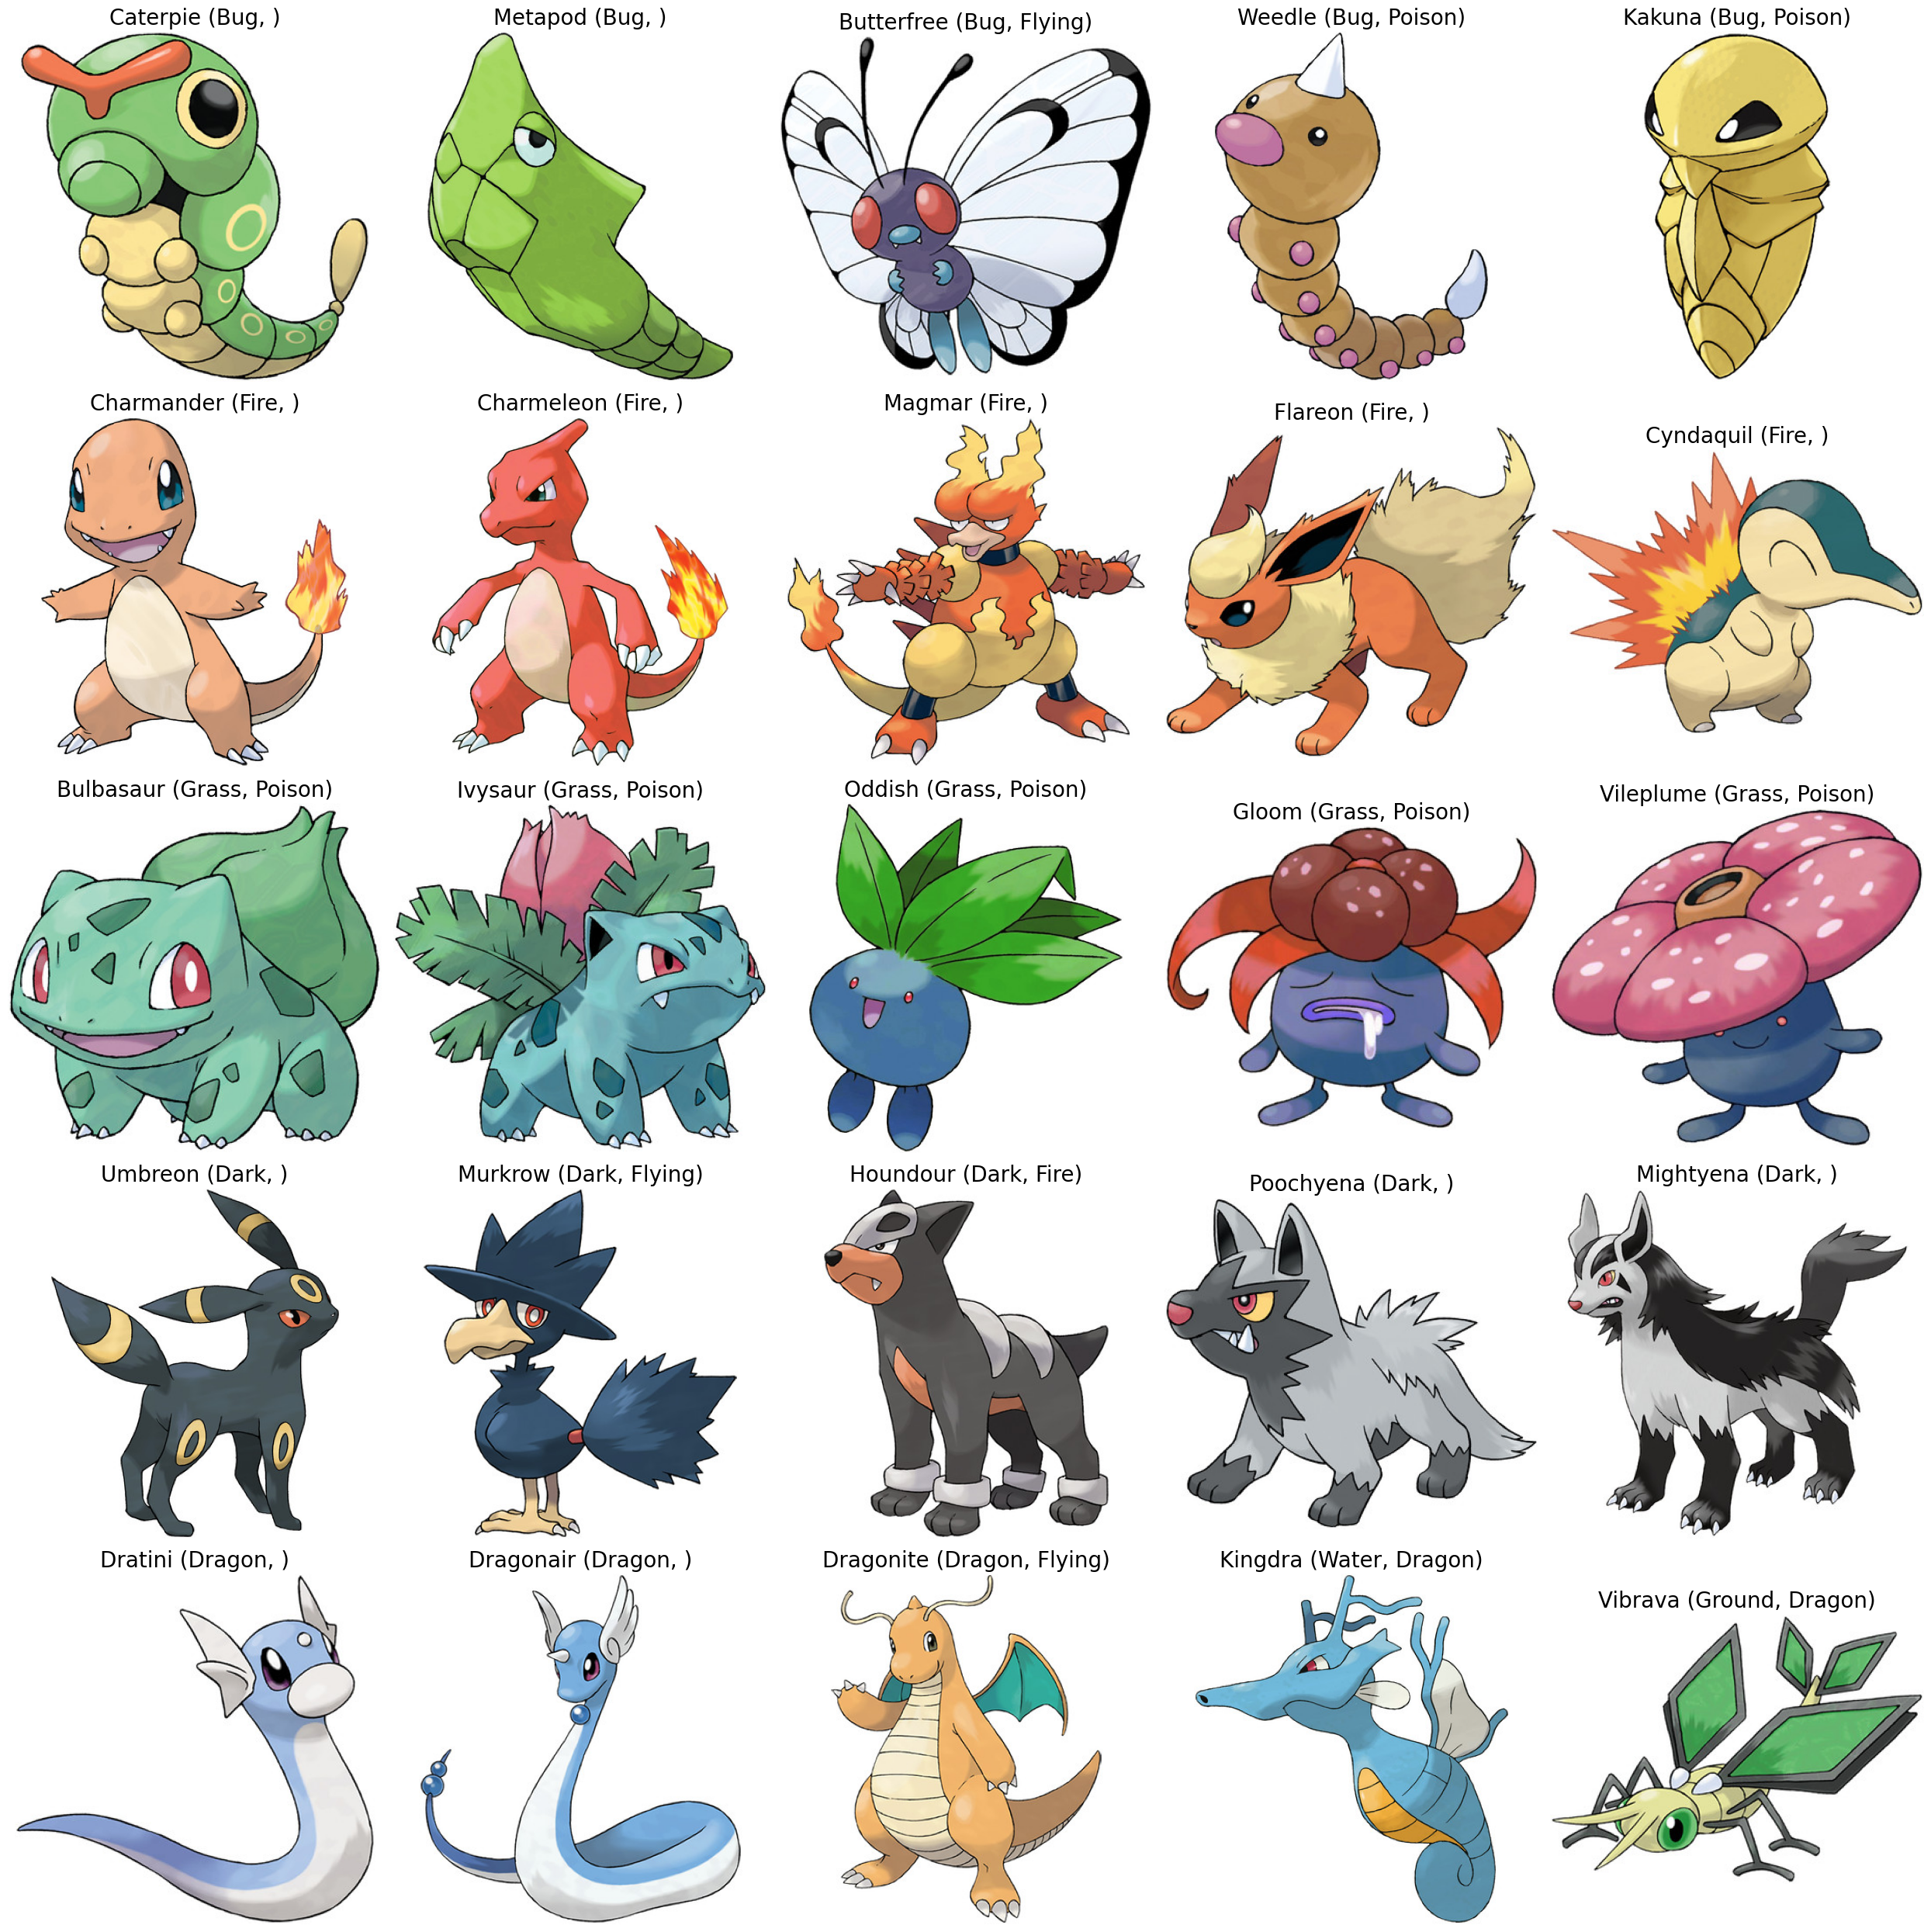

In [167]:
import matplotlib.pyplot as plt

# Construct the pokedex DataFrame
pokedex = construct_pokedex(csv_path='Pokemon.csv', image_dir='./images/')

# Define queries for Bug, Fire, Grass, Dark, and Dragon types
queries = {
    "Bug": "type: Bug",
    "Fire": "type: Fire",
    "Grass": "type: Grass",
    "Dark": "type: Dark",
    "Dragon": "type: Dragon"
}

# Plot
fig, axes = plt.subplots(nrows = 5, ncols = 5, figsize = (25, 25))

# Iterate over each type and construct queries
for i, (type_name, query) in enumerate(queries.items()):
    # Find the Pokémon matching the query
    matching_pokemon = pokedex[pokedex["Type1"].str.contains(type_name, case = False) | 
                               pokedex["Type2"].str.contains(type_name, case = False)].head(5)

    # Plot the top five most relevant Pokémon horizontally
    for j, (_, pokemon) in enumerate(matching_pokemon.iterrows()):
        img = Image.open(pokemon["image_path"])
        ax = axes[i, j]
        ax.imshow(img)
        ax.set_title(f"{pokemon['Name']} ({pokemon['Type1']}, {pokemon['Type2']})", fontsize = 20)
        ax.axis("off")

# Display Plot
plt.tight_layout()
plt.show()


In [150]:
print(pokedex)

      ID        Name Form     Type1   Type2  Total   HP  Attack  Defense  \
0      1   Bulbasaur          Grass  Poison    318   45      49       49   
1      2     Ivysaur          Grass  Poison    405   60      62       63   
2      4  Charmander           Fire            309   39      52       43   
3      5  Charmeleon           Fire            405   58      64       58   
4      7    Squirtle          Water            314   44      48       65   
..   ...         ...  ...       ...     ...    ...  ...     ...      ...   
749  893      Zarude           Dark   Grass    600  105     120      105   
750  894   Regieleki       Electric            580   80     100       50   
751  895   Regidrago         Dragon            580  200     100       50   
752  896   Glastrier            Ice            580  100     145      130   
753  897   Spectrier          Ghost            580  100      65       60   

     Sp. Atk  Sp. Def  Speed  Generation                  image_path  
0         65    

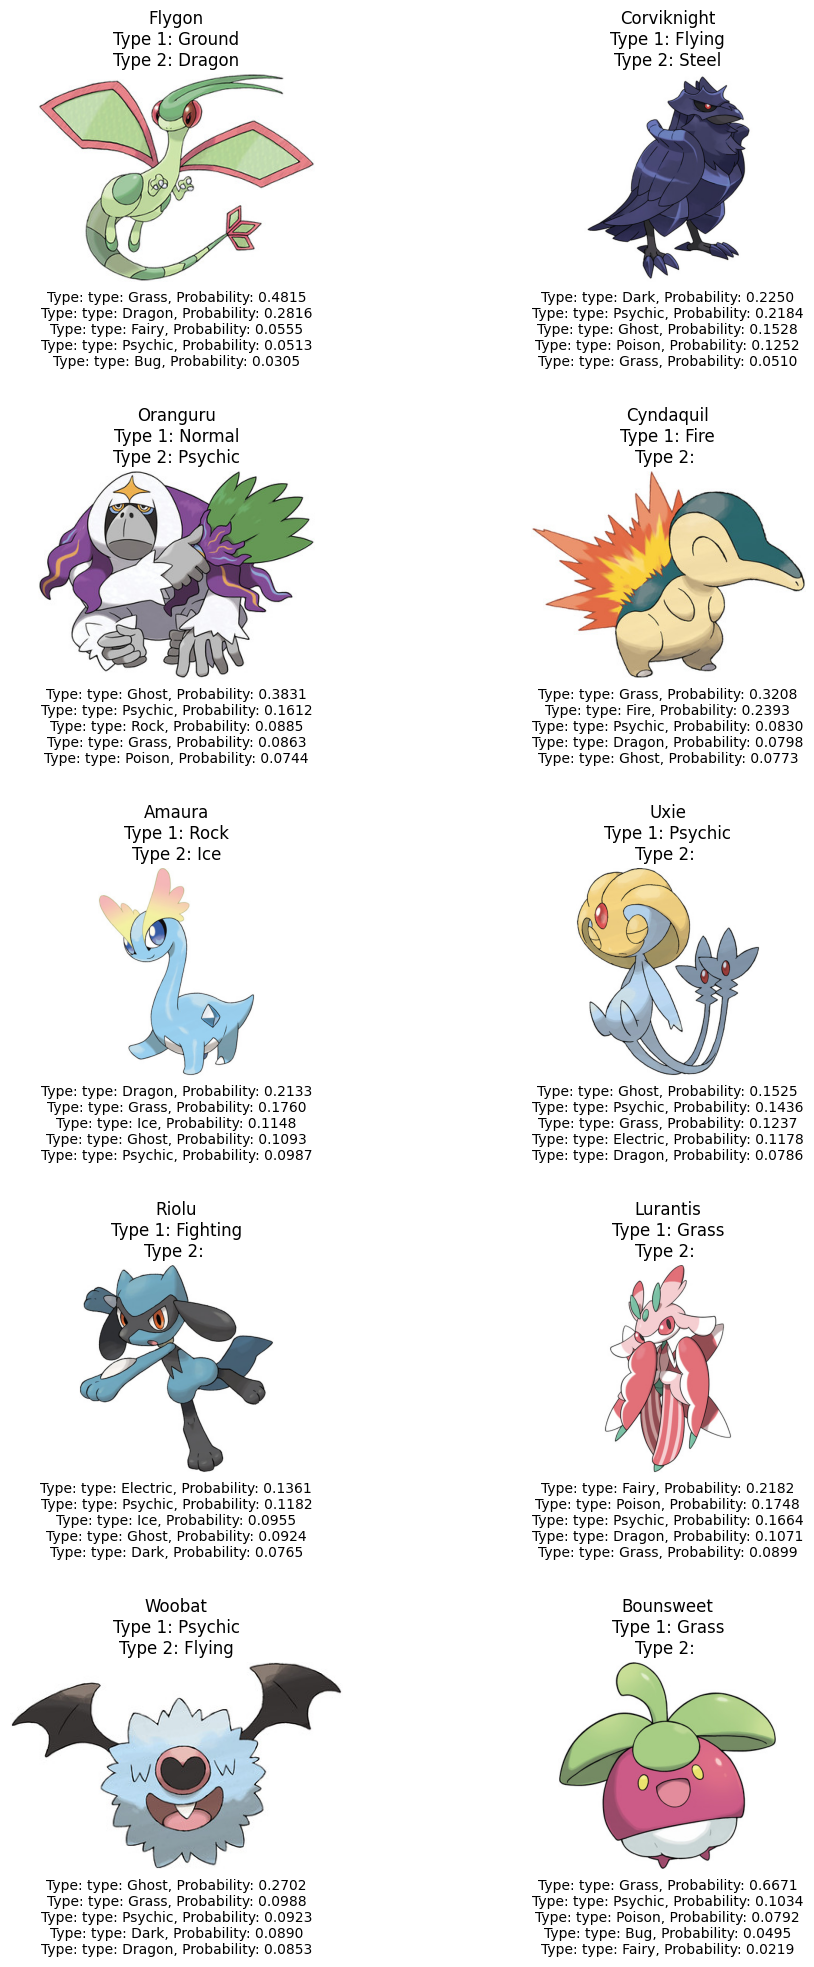

In [163]:
import pandas as pd
import numpy as np
from glob import glob
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt

# Load CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load Pokédex data
def load_pokedex(csv_path='Pokemon.csv', image_dir='./images/'):
    pokedex = pd.read_csv(csv_path)
    image_paths = []

    for pokemon_name in pokedex["Name"]:
        imgs = glob(f"{image_dir}/{pokemon_name}/0.jpg")
        if len(imgs) > 0:
            image_paths.append(imgs[0])
        else:
            image_paths.append(None)

    pokedex["image_path"] = image_paths
    pokedex = pokedex[pokedex["image_path"].notna()].reset_index(drop=True)

    # Only keep Pokémon with distinct ID
    ids, id_counts = np.unique(pokedex["ID"], return_counts=True)
    ids, id_counts = np.array(ids), np.array(id_counts)
    keep_ids = ids[id_counts == 1]

    pokedex = pokedex[pokedex["ID"].isin(keep_ids)].reset_index(drop=True)
    pokedex["Type2"] = pokedex["Type2"].str.strip()

    return pokedex

# Get predicted types and probabilities for a given Pokémon
def get_predicted_types_and_probs(pokemon_name, image_path):
    
    queries = [
        "type: Normal",
        "type: Fire",
        "type: Water",
        "type: Grass",
        "type: Flying",
        "type: Fighting",
        "type: Poison",
        "type: Electric",
        "type: Ground",
        "type: Rock",
        "type: Psychic",
        "type: Ice",
        "type: Bug",
        "type: Ghost",
        "type: Steel",
        "type: Dragon",
        "type: Dark",
        "type: Fairy"
    ]

    
    inputs = clip_processor(text=queries, return_tensors="pt", padding=True)

    # Load image and preprocess it
    image = Image.open(image_path)
    inputs["pixel_values"] = clip_processor(images=image, return_tensors="pt")["pixel_values"]

    # Pass inputs through the model
    with torch.no_grad():
        outputs = clip_model(**inputs)

    # Get the predicted probabilities for text
    text_probs = torch.nn.functional.softmax(outputs.logits_per_image, dim=-1)

    # Get the top 5 predicted types and their probabilities for text
    top_text_probs, top_text_indices = torch.topk(text_probs[0], min(5, text_probs.size(-1)))
    predicted_text_types = [queries[i] for i in top_text_indices]

    return predicted_text_types, top_text_probs.tolist()

# Load Pokédex
pokedex = load_pokedex()

# Randomly select 10 Pokémon from the Pokédex
random_pokemon_indices = np.random.choice(len(pokedex), size=10, replace=False)
random_pokemon_subset = pokedex.iloc[random_pokemon_indices]

# Plot Pokémon images with prediction info
fig, axes = plt.subplots(5, 2, figsize=(10, 20))

for i, (index, row) in enumerate(random_pokemon_subset.iterrows()):
    pokemon_name = row["Name"]
    type1 = row["Type1"]
    type2 = row["Type2"]
    image_path = row["image_path"]

    predicted_text_types, predicted_text_probs = get_predicted_types_and_probs(pokemon_name, image_path)

    img = Image.open(image_path)
    axes[i // 2, i % 2].imshow(img)
    axes[i // 2, i % 2].set_title(f"{pokemon_name}\nType 1: {type1}\nType 2: {type2}")
    axes[i // 2, i % 2].axis('off')

    info = "\n".join([f"Type: {t}, Probability: {p:.4f}" for t, p in zip(predicted_text_types, predicted_text_probs)])
    axes[i // 2, i % 2].text(0.5, -0.4, info, ha='center', transform=axes[i // 2, i % 2].transAxes, fontsize=10)

plt.tight_layout()
plt.show()


In [164]:
from PIL import Image
from sklearn.manifold import TSNE
import plotly.express as px

# Filter Pokémon types Bug, Fire, and Grass
bug_fire_grass = pokedex[pokedex['Type1'].isin(['Bug', 'Fire', 'Grass'])]

# Load and preprocess Pokémon images
images = []
pokemon_names = []
for _, row in bug_fire_grass.iterrows():
    img_path = f'./images/{row["Name"]}/0.jpg'
    try:
        img = Image.open(img_path).resize((224, 224))  # Resize image to match CLIP input size
        img_array = np.array(img) / 255.0  # Normalize pixel values
        images.append(img_array.flatten())  # Flatten image array
        pokemon_names.append(row["Name"])
    except FileNotFoundError:
        pass

images = np.array(images)

# Apply t-SNE to embed images
tsne = TSNE(n_components=2, random_state=42)
image_embeddings = tsne.fit_transform(images)

# Create a new DFfor embeddings
embedding_df = pd.DataFrame(image_embeddings, columns=['tsne_x', 'tsne_y'], index=pokemon_names)

# Merge embeddings DataFrame
bug_fire_grass = bug_fire_grass.merge(embedding_df, left_on='Name', right_index=True)

# Create the scatter plot
fig = px.scatter(bug_fire_grass, x='tsne_x', y='tsne_y', color='Type1', hover_name='Name',
                 title='t-SNE Visualization of Pokémon Types (Bug, Fire, Grass)',
                 labels={'tsne_x': 't-SNE Dimension 1', 'tsne_y': 't-SNE Dimension 2'},
                 color_discrete_map={'Bug': 'green', 'Fire': 'red', 'Grass': 'blue'})

# Save the plot to an external HTML file
plot(fig, filename='pokemon_tsne.html')

Number of Pokémon images processed: 192
Range of t-SNE embeddings (x-axis): -90.33493 - 93.49499
Range of t-SNE embeddings (y-axis): -130.68774 - 117.97606


'pokemon_tsne.html'